In [ ]:
%load_ext autoreload
%autoreload 2

In [40]:
from pathlib import Path
from usagestats.bookingdb import BookingDB
from datetime import datetime, timedelta
import pytz
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from usagestats import visual

db_file = "bookings.db"
folder = Path(
    "/run/user/1000/gvfs/smb-share:server=istore,share=microscopy_group_share,user=jeromeb/Admin/Usage Stats/2024"
)

local_tz = pytz.timezone("Europe/London")
num_weeks = 2*52
start_date = datetime.fromisoformat("2022-11-02").replace(tzinfo=local_tz)
end_date = start_date + timedelta(weeks=num_weeks)  # iso-format data yyyy-mm-dd
drop_bookings_type = ["service", "maintenance", "training"]
drop_instrument = [
    "Analysis PC1",
    "Analysis PC2",
    "Analysis PC3",
    "Analysis PC4"]

with BookingDB(db_file) as db:
    bookings = db.get_events_in_range(start_date, end_date)

# fix booking types
def get_type_from_str(x):
    types = {'serv':'service','maint':'maintenance','train':'training','maintenace':'maintenance'}
    for y in types:
        if x.lower().find(y)>=0:
            return types[y]
    return 'default'

bookings['type'] = [get_type_from_str(x) for x in bookings['subject']]

In [41]:
# excludes special bookings
bookings = bookings[~bookings["type"].isin(drop_bookings_type)]
# excludes instruments
bookings = bookings[~bookings["instrument"].isin(drop_instrument)]
# exclude unknown
bookings = bookings[bookings["group"]!="Unknown"]
bookings = bookings[bookings["division"]!="Unknown"]
bookings.head()

,hours,start,end,user,group,division,instrument,type,subject
3623,15.0,2024-10-02 18:01:00+00:00,2024-10-03 09:01:00+00:00,Anna Jansson,Schafer,Neurobiology,Andor BC43,default,anna
3624,1.0,2024-10-21 13:31:00+00:00,2024-10-21 14:31:00+00:00,Sarah Lecinski,Light Microscopy,Cell Biology,Andor BC43,default,sarah andor
3625,3.0,2024-09-23 15:01:00+00:00,2024-09-23 18:01:00+00:00,Oliver Knowles,Allegretti,Structural Studies,Andor BC43,default,oliver
3627,3.0,2024-06-17 14:01:00+00:00,2024-06-17 17:01:00+00:00,Oliver Knowles,Allegretti,Structural Studies,Andor BC43,default,oliver
3628,2.0,2024-05-21 14:31:00+00:00,2024-05-21 16:31:00+00:00,Feline Lindhout,Lancaster,Cell Biology,Andor BC43,default,feline lindhout


In [42]:
# bookings['year'] =  bookings['start'] > start_date + timedelta(weeks=52)
bookings.loc[bookings['start'] > start_date + timedelta(weeks=52),'year'] = 2024
bookings.loc[bookings['start'] <= start_date + timedelta(weeks=52),'year'] = 2023
bookings['year'] = bookings['year'].astype(int)

<Axes: xlabel='hours', ylabel='instrument'>

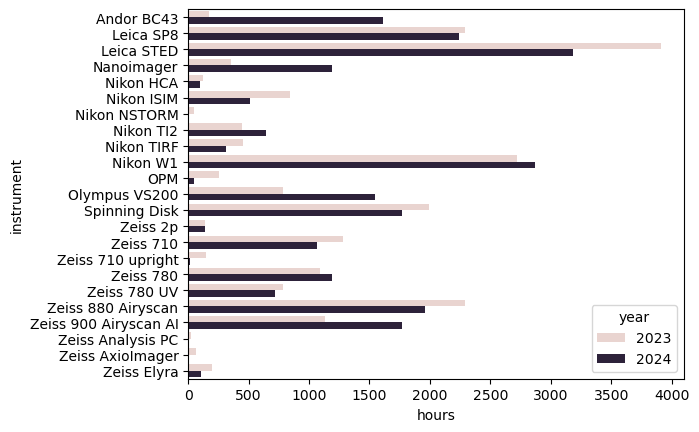

In [37]:
stats = bookings.groupby(['instrument','year']).agg(hours=pd.NamedAgg(column="hours", aggfunc="sum"))#.pivot_table(index="instrument",columns="year",values="hours")
sns.barplot(data=stats,y='instrument',x='hours',hue='year')

Text(0.5, 0, 'Number of hours')

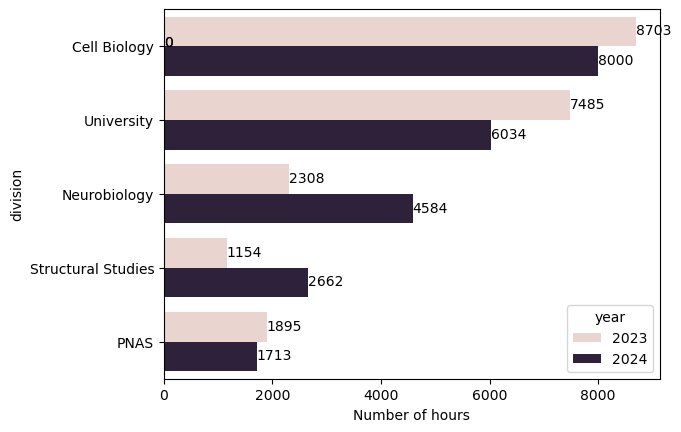

In [43]:
stats = (
    bookings.groupby(["division","year"])
    .agg(hours=pd.NamedAgg(column="hours", aggfunc="sum"))
    .sort_values("hours", ascending=False)
)

ax = sns.barplot(data=stats, x="hours", y="division", hue="year")
visual.show_values_on_bars(ax,'h',hspace=0.4)
plt.xlabel('Number of hours')
# plt.title('Number of hours per division'+info_str)
# plt.savefig(folder/'hours-per-division.pdf',pad_inches=1.2,bbox_inches='tight')

hours
instrument            year              
Analysis PC1          False  1698.000000
                      True   1659.500000
Analysis PC2          False  1657.000000
                      True   1728.750000
Analysis PC3          False  1508.850000
                      True   1350.500000
Analysis PC4          False  1142.250000
                      True   1674.000000
Andor BC43            False   193.000000
                      True   1830.000000
Leica SP8             False  2511.500000
                      True   2439.000000
Leica STED            False  4144.250000
                      True   3333.750000
Nanoimager            False   385.500000
                      True   1191.500000
Nikon HCA             False   375.000000
                      True    131.500000
Nikon ISIM            False   970.000000
                      True    637.500000
Nikon NSTORM          False   112.000000
                      True      6.000000
Nikon TI2             False   511.250000
                      True    659.250000
Nikon TIRF            False   530.000000
                      True    370.000000
Nikon W1              False  2914.500000
                      True   2979.000000
OPM                   False   255.500000
                      True     50.000000
Olympus VS200         False   929.000000
                      True   1776.250000
Spinning Disk         False  2388.483333
                      True   1840.000000
Zeiss 2p              False   261.000000
                      True    174.000000
Zeiss 710             False  1400.000000
                      True   1135.000000
Zeiss 710 upright     False   304.000000
                      True     34.500000
Zeiss 780             False  1203.333333
                      True   1293.583333
Zeiss 780 UV          False   957.250000
                      True    988.250000
Zeiss 880 Airyscan    False  2599.750000
                      True   2109.583333
Zeiss 900 Airyscan AI False  1276.500000
                      True   1932.000000
Zeiss Analysis PC     False    38.000000
Zeiss AxioImager      False    84.500000
                      True     21.000000
Zeiss Elyra           False   265.500000
                      True    157.000000